Using Decision Trees / Logistic Regression to detect fake bills

Import the dataset


In [1]:
import pandas as pd

df = pd.read_csv("fake_bills.csv", sep=';')

Dataset analysis:

The dataset includes 1500 rows and 7 columns:

is_genuine: boolean
diagonal: float
height_left: float
height_right: float
margin_low: float
margin_upper: float
length: float

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [12]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [13]:
print("Shape of the dataset " + str(df.shape))

Shape of the dataset (1500, 7)


Check if we have duplicates instances

In [14]:
print('Number of duplicate instances: ' + str(df.duplicated().sum()))

Number of duplicate instances: 0


Check now if we have some null data among the instances.

In [15]:
print('Number of null features: \n' + str(df.isnull().sum()))

Number of null features: 
is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


In [3]:
# calculate the mean of each column
mean_margin_low_true = df.loc[df['is_genuine'] == True, 'margin_low'].mean()
mean_margin_low_false = df.loc[df['is_genuine'] == False, 'margin_low'].mean()

In [4]:
# Replace the missing value with the mean of the rest
df.loc[df['is_genuine'] == True, 'margin_low'] = df.loc[df['is_genuine'] == True, 'margin_low'].fillna(mean_margin_low_true)
df.loc[df['is_genuine'] == False, 'margin_low'] = df.loc[df['is_genuine'] == False, 'margin_low'].fillna(mean_margin_low_false)

In [18]:
print('Number of null features: \n' + str(df.isnull().sum()))

Number of null features: 
is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


Let's see what the distribution of data looks like

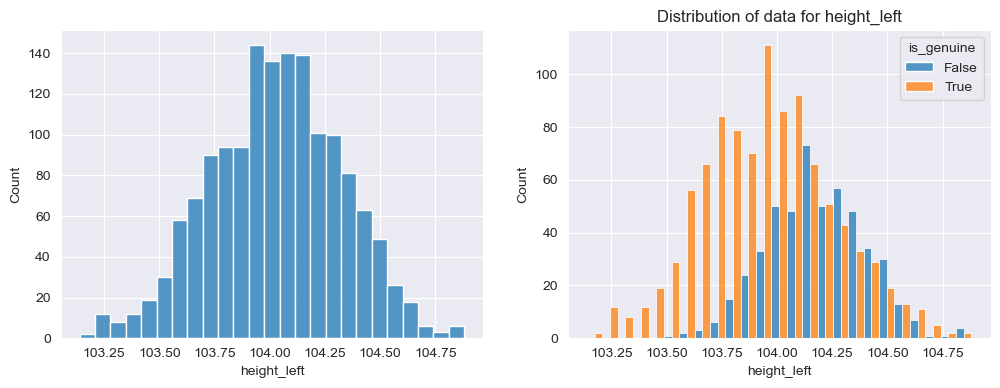

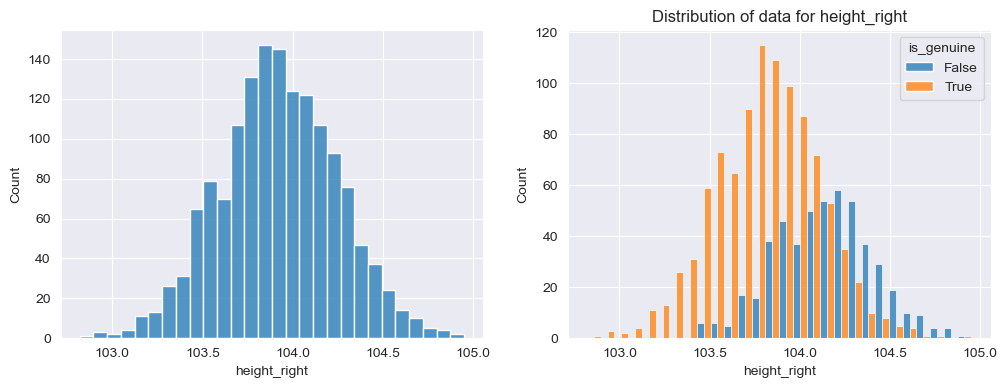

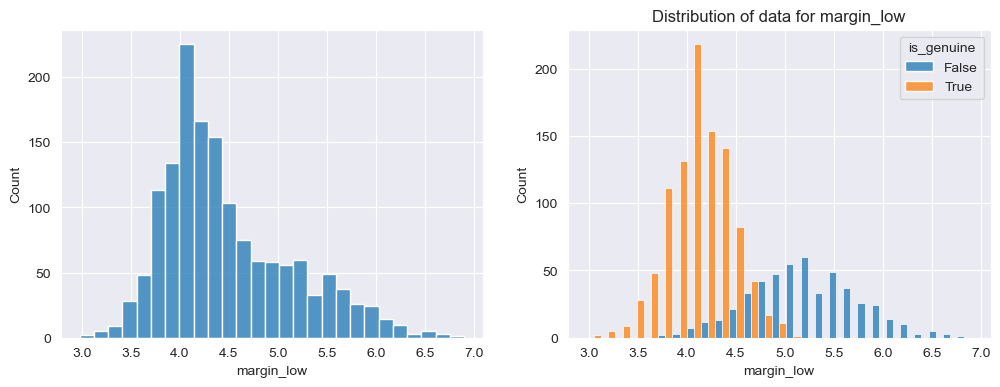

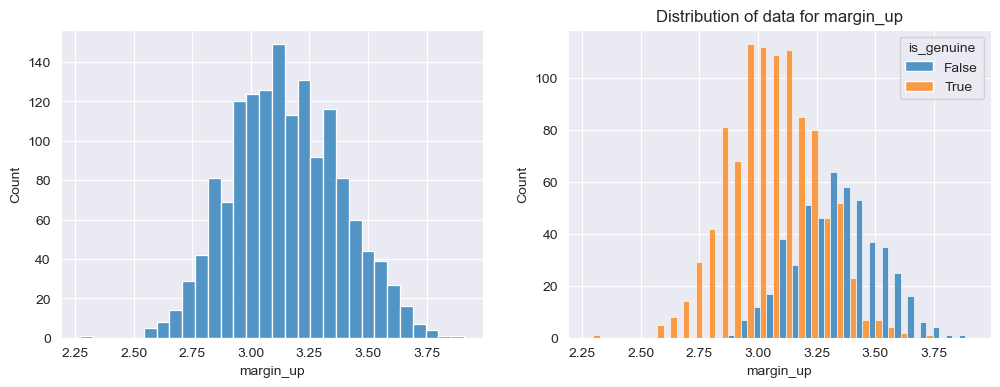

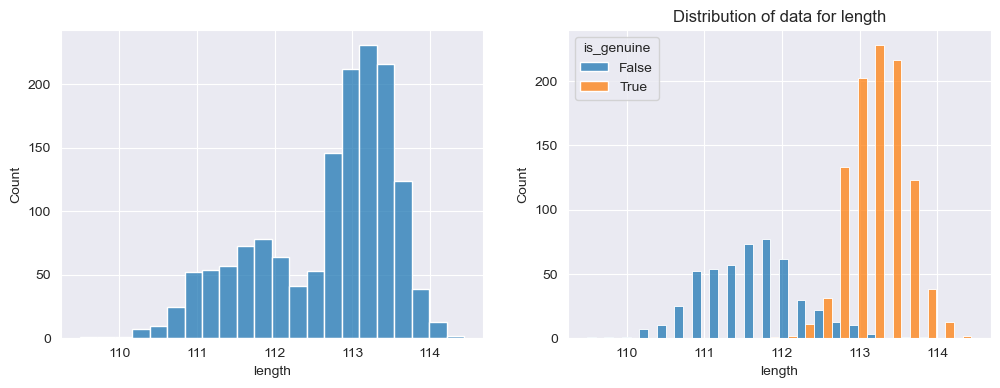

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in df.columns[2:]:
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    sns.histplot(data=df, x=col, ax=ax[0])
    sns.histplot(data=df, x=col, hue='is_genuine', ax=ax[1], multiple='dodge')
    plt.title(f"Distribution of data for {col}")
    plt.show()

In [20]:
df.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.786136,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.110301,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.308501,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.390737,0.307005,-0.401751
margin_low,-0.786136,-0.110301,0.308501,0.390737,1.000000,0.431172,-0.668636
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431172,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.668636,-0.520575,1.000000


<AxesSubplot:>

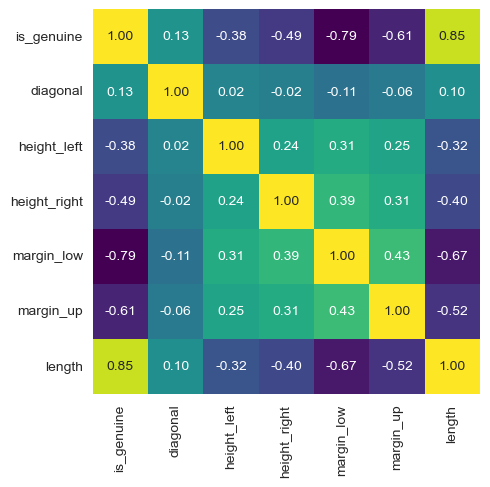

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,5))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cbar=None,cmap='viridis')

In [23]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.482710,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659735,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.030000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Transform labels to numeric data

In [24]:
df['is_genuine'].unique()

array([ True, False])

In [5]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
df["is_genuine"] = labelEncoder.fit_transform(df["is_genuine"])

Split the dataset in test + train

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('is_genuine', axis=1)
y = df['is_genuine'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Let's try some models first

In [90]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

for depth in range(10):
    decisionTreeClassifierModel = DecisionTreeClassifier(
        criterion='gini',
        max_depth=depth+1,
        random_state=1
    )

    # Fit the algorithm to the training data.
    decisionTreeClassifierModel.fit(X_train, y_train)
    predictions = decisionTreeClassifierModel.predict(X_test)
    cls_report = classification_report(y_test, predictions, output_dict=True)
    print('Depth: ' + str(depth + 1))
    print('Acc ' + str(cls_report['accuracy']))

Depth: 1
Acc 0.95
Depth: 2
Acc 0.9633333333333334
Depth: 3
Acc 0.9566666666666667
Depth: 4
Acc 0.9633333333333334
Depth: 5
Acc 0.97
Depth: 6
Acc 0.9666666666666667
Depth: 7
Acc 0.9666666666666667
Depth: 8
Acc 0.9666666666666667
Depth: 9
Acc 0.9666666666666667
Depth: 10
Acc 0.9666666666666667


In [91]:

for depth in range(10):
    decisionTreeClassifierModel = DecisionTreeClassifier(
        criterion='entropy',
        max_depth=depth + 1,
        random_state=1
    )

    # Fit the algorithm to the training data.
    decisionTreeClassifierModel.fit(X_train, y_train)
    predictions = decisionTreeClassifierModel.predict(X_test)
    cls_report = classification_report(y_test, predictions, output_dict=True)
    print('Depth: ' + str(depth + 1))
    print('Acc ' + str(cls_report['accuracy']))


Depth: 1
Acc 0.95
Depth: 2
Acc 0.9633333333333334
Depth: 3
Acc 0.9866666666666667
Depth: 4
Acc 0.9766666666666667
Depth: 5
Acc 0.9833333333333333
Depth: 6
Acc 0.9833333333333333
Depth: 7
Acc 0.9833333333333333
Depth: 8
Acc 0.9833333333333333
Depth: 9
Acc 0.9833333333333333
Depth: 10
Acc 0.9833333333333333


Let's try standardisation

In [7]:
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=1)

This is called Grid Search

In [113]:
from sklearn.model_selection import GridSearchCV

# define the hyperparameters to search
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

decisionTreeClassifierModel = DecisionTreeClassifier(
    random_state=1
)

# create the grid search object
grid_search = GridSearchCV(decisionTreeClassifierModel, param_grid, cv=5)

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'max_depth': 3}


What about Standardize the data

In [114]:

decisionTreeClassifierModel = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=3,
    random_state=1
)

# Fit the algorithm to the training data.
decisionTreeClassifierModel.fit(X_train, y_train)
predictions = decisionTreeClassifierModel.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98        98
           1       0.99      0.99      0.99       202

    accuracy                           0.99       300
   macro avg       0.98      0.99      0.98       300
weighted avg       0.99      0.99      0.99       300



What about random forrest ?

In [120]:
from sklearn.ensemble import RandomForestClassifier


# define the hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 120, 150, 180, 200],
    'max_depth': [1 ,2 , 3, 4, 5, 6]
}

randomForestClassifierModel = RandomForestClassifier(
    random_state=1
)

# create the grid search object
grid_search = GridSearchCV(randomForestClassifierModel, param_grid, cv=5)

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'max_depth': 4, 'n_estimators': 100}


In [121]:
randomForestClassifierModel = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    random_state=1
)

# Fit the algorithm to the training data.
randomForestClassifierModel.fit(X_train, y_train)
predictions = randomForestClassifierModel.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        98
           1       1.00      1.00      1.00       202

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300



Bonus: Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logisticRegModel = LogisticRegression(random_state=1)
logisticRegModel.fit(X_train, y_train)
predictions = logisticRegModel.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        98
           1       1.00      1.00      1.00       202

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300



Random Experiment: Try training just on length and margin_low

In [11]:
df = df[['is_genuine', 'length', 'margin_low']]
X = df.drop('is_genuine', axis=1)
y = df['is_genuine'].values

X_std = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=1)

In [12]:
logisticRegModel = LogisticRegression(random_state=1)
logisticRegModel.fit(X_train, y_train)
predictions = logisticRegModel.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        98
           1       0.99      0.99      0.99       202

    accuracy                           0.99       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



Homework: Further Analysis -> PCA - Principal Component Analysis